In [1]:
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection
%matplotlib inline

In [2]:
#load and preprocess data
def read_in_and_split_data(iris_data):
    """
    Takes the Iris dataset as loaded by sklearn.datasets.load_iris(), and then splits so that the training set includes 
    90% of the full dataset, with the test set making up the remaining 10%.
    Returns a tuple (train_data, test_data, train_targets, test_targets) of appropriately split training and test data and 
    targets.
    """
    data = iris_data['data']
    targets = iris_data['target']
    
    train_data, test_data, train_targets, test_targets = model_selection.train_test_split(data, targets, test_size = 0.1)
    
    return train_data, test_data, train_targets, test_targets

iris_data = datasets.load_iris()
train_data, test_data, train_targets, test_targets = read_in_and_split_data(iris_data)

In [3]:
#covert targets to a one-hot encoding
train_targets = tf.keras.utils.to_categorical(np.array(train_targets))
test_targets = tf.keras.utils.to_categorical(np.array(test_targets))

In [4]:
#build the model
def get_model(input_shape):
    """
    Builds and returns a Sequential model.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape = (train_data.shape[1],), 
                              kernel_initializer = tf.keras.initializers.HeUniform(),
                             bias_initializer = tf.keras.initializers.Constant(value=0)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(3, activation = 'softmax'),
        
    ])
    return model

model = get_model(train_data[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4

In [5]:
#compile the model
def compile_model(model):
    """
    Takes in the model returned from your get_model function, and compiles it with an optimiser, loss function and metric.
    Compile the model using the Adam optimiser (with learning rate set to 0.0001), the categorical crossentropy loss function 
    and accuracy as the only metric. 
    """
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy']
    )
compile_model(model)

In [6]:
#model training
def train_model(model, train_data, train_targets, epochs):
    """
    Train the model for the given number of epochs on the train_data and train_targets. 
    Return the training history, as returned by model.fit.
    """
    history = model.fit(train_data, train_targets, epochs = epochs, batch_size = 40, validation_split = 0.15)
    return history

history = train_model(model, train_data, train_targets, epochs = 800)

Epoch 1/800
3/3 [==============================] - 1s 163ms/step - loss: 1.0917 - accuracy: 0.3158 - val_loss: 0.9802 - val_accuracy: 0.4286
Epoch 2/800
3/3 [==============================] - 0s 15ms/step - loss: 1.0101 - accuracy: 0.3158 - val_loss: 0.9417 - val_accuracy: 0.4286
Epoch 3/800
3/3 [==============================] - 0s 15ms/step - loss: 0.9658 - accuracy: 0.3158 - val_loss: 0.9094 - val_accuracy: 0.4286
Epoch 4/800
3/3 [==============================] - 0s 15ms/step - loss: 0.9250 - accuracy: 0.3158 - val_loss: 0.8820 - val_accuracy: 0.6190
Epoch 5/800
3/3 [==============================] - 0s 13ms/step - loss: 0.8861 - accuracy: 0.6140 - val_loss: 0.8511 - val_accuracy: 0.6667
Epoch 6/800
3/3 [==============================] - 0s 14ms/step - loss: 0.8505 - accuracy: 0.8421 - val_loss: 0.8227 - val_accuracy: 0.9048
Epoch 7/800
3/3 [==============================] - 0s 15ms/step - loss: 0.8124 - accuracy: 0.9737 - val_loss: 0.7966 - val_accuracy: 0.9524
Epoch 8/800
3/3 [==

3/3 [==============================] - 0s 15ms/step - loss: 0.0730 - accuracy: 0.9825 - val_loss: 0.2214 - val_accuracy: 0.9048
Epoch 60/800
3/3 [==============================] - 0s 15ms/step - loss: 0.0871 - accuracy: 0.9737 - val_loss: 0.2219 - val_accuracy: 0.9048
Epoch 61/800
3/3 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - 0s 27ms/step - loss: 0.0881 - accuracy: 0.9561 - val_loss: 0.1747 - val_accuracy: 0.9048
Epoch 62/800
3/3 [==============================] - 0s 43ms/step - loss: 0.0852 - accuracy: 0.9649 - val_loss: 0.2352 - val_accuracy: 0.9048
Epoch 63/800
3/3 [==============================] - 0s 30ms/step - loss: 0.0751 - accuracy: 0.9737 - val_loss: 0.2341 - val_accuracy: 0.9048
Epoch 64/800
3/3 [==============================] - 0s 29ms/step - loss: 0.0693 - accuracy: 0.9825 - val_loss: 0.1936 - val_accuracy: 0.9524
Epoch 65/800
3/3 [==============================] - 0s 27ms/step - loss: 0.0723 - accuracy: 0.9737 - val_loss: 0.2149 - val_a

Epoch 117/800
3/3 [==============================] - 0s 17ms/step - loss: 0.0384 - accuracy: 0.9825 - val_loss: 0.2631 - val_accuracy: 0.9524
Epoch 118/800
3/3 [==============================] - 0s 20ms/step - loss: 0.0409 - accuracy: 0.9825 - val_loss: 0.2816 - val_accuracy: 0.9524
Epoch 119/800
3/3 [==============================] - 0s 17ms/step - loss: 0.0378 - accuracy: 0.9825 - val_loss: 0.2718 - val_accuracy: 0.9524
Epoch 120/800
3/3 [==============================] - 0s 21ms/step - loss: 0.0386 - accuracy: 0.9825 - val_loss: 0.2729 - val_accuracy: 0.9524
Epoch 121/800
3/3 [==============================] - 0s 16ms/step - loss: 0.0446 - accuracy: 0.9825 - val_loss: 0.2998 - val_accuracy: 0.9524
Epoch 122/800
3/3 [==============================] - 0s 17ms/step - loss: 0.0390 - accuracy: 0.9825 - val_loss: 0.2640 - val_accuracy: 0.9524
Epoch 123/800
3/3 [==============================] - 0s 19ms/step - loss: 0.0456 - accuracy: 0.9825 - val_loss: 0.2858 - val_accuracy: 0.9524
Epoch 

3/3 [==============================] - 0s 13ms/step - loss: 0.0290 - accuracy: 0.9825 - val_loss: 0.3366 - val_accuracy: 0.9524
Epoch 175/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0300 - accuracy: 0.9825 - val_loss: 0.3344 - val_accuracy: 0.9524
Epoch 176/800
3/3 [==============================] - 0s 11ms/step - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.3056 - val_accuracy: 0.9524
Epoch 177/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.3219 - val_accuracy: 0.9524
Epoch 178/800
3/3 [==============================] - 0s 15ms/step - loss: 0.0264 - accuracy: 0.9825 - val_loss: 0.3423 - val_accuracy: 0.9524
Epoch 179/800
3/3 [==============================] - 0s 16ms/step - loss: 0.0288 - accuracy: 0.9825 - val_loss: 0.3302 - val_accuracy: 0.9524
Epoch 180/800
3/3 [==============================] - 0s 17ms/step - loss: 0.0273 - accuracy: 0.9825 - val_loss: 0.3099 - val_accuracy: 0.9524
Epoch 181/800
3/3 [=

Epoch 232/800
3/3 [==============================] - 0s 26ms/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.3477 - val_accuracy: 0.9524
Epoch 233/800
3/3 [==============================] - 0s 47ms/step - loss: 0.0212 - accuracy: 1.0000 - val_loss: 0.3690 - val_accuracy: 0.9524
Epoch 234/800
3/3 [==============================] - 0s 34ms/step - loss: 0.0221 - accuracy: 0.9825 - val_loss: 0.3703 - val_accuracy: 0.9524
Epoch 235/800
3/3 [==============================] - 0s 17ms/step - loss: 0.0226 - accuracy: 0.9825 - val_loss: 0.3647 - val_accuracy: 0.9524
Epoch 236/800
3/3 [==============================] - 0s 19ms/step - loss: 0.0304 - accuracy: 0.9912 - val_loss: 0.3532 - val_accuracy: 0.9524
Epoch 237/800
3/3 [==============================] - 0s 14ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.3906 - val_accuracy: 0.9524
Epoch 238/800
3/3 [==============================] - 0s 17ms/step - loss: 0.0307 - accuracy: 0.9825 - val_loss: 0.3776 - val_accuracy: 0.9524
Epoch 

Epoch 290/800
3/3 [==============================] - 0s 16ms/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.3785 - val_accuracy: 0.9524
Epoch 291/800
3/3 [==============================] - 0s 16ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.4051 - val_accuracy: 0.9524
Epoch 292/800
3/3 [==============================] - 0s 21ms/step - loss: 0.0282 - accuracy: 0.9825 - val_loss: 0.3978 - val_accuracy: 0.9524
Epoch 293/800
3/3 [==============================] - 0s 15ms/step - loss: 0.0183 - accuracy: 0.9912 - val_loss: 0.3798 - val_accuracy: 0.9524
Epoch 294/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.3975 - val_accuracy: 0.9524
Epoch 295/800
3/3 [==============================] - 0s 18ms/step - loss: 0.0162 - accuracy: 0.9912 - val_loss: 0.4073 - val_accuracy: 0.9524
Epoch 296/800
3/3 [==============================] - 0s 39ms/step - loss: 0.0227 - accuracy: 0.9825 - val_loss: 0.3930 - val_accuracy: 0.9524
Epoch 

3/3 [==============================] - 0s 15ms/step - loss: 0.0200 - accuracy: 0.9912 - val_loss: 0.3967 - val_accuracy: 0.9524
Epoch 348/800
3/3 [==============================] - 0s 14ms/step - loss: 0.0151 - accuracy: 0.9912 - val_loss: 0.4136 - val_accuracy: 0.9524
Epoch 349/800
3/3 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.9825 - val_loss: 0.4053 - val_accuracy: 0.9524
Epoch 350/800
3/3 [==============================] - 0s 15ms/step - loss: 0.0247 - accuracy: 0.9825 - val_loss: 0.3911 - val_accuracy: 0.9524
Epoch 351/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0292 - accuracy: 1.0000 - val_loss: 0.4213 - val_accuracy: 0.9524
Epoch 352/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0245 - accuracy: 0.9825 - val_loss: 0.4123 - val_accuracy: 0.9524
Epoch 353/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0127 - accuracy: 0.9912 - val_loss: 0.3964 - val_accuracy: 0.9524
Epoch 354/800
3/3 [=

Epoch 405/800
3/3 [==============================] - 0s 15ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.4367 - val_accuracy: 0.9524
Epoch 406/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.4357 - val_accuracy: 0.9524
Epoch 407/800
3/3 [==============================] - 0s 14ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.4346 - val_accuracy: 0.9524
Epoch 408/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4459 - val_accuracy: 0.9524
Epoch 409/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0120 - accuracy: 0.9912 - val_loss: 0.4377 - val_accuracy: 0.9524
Epoch 410/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.4396 - val_accuracy: 0.9524
Epoch 411/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.4354 - val_accuracy: 0.9524
Epoch 

Epoch 463/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4601 - val_accuracy: 0.9524
Epoch 464/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.4560 - val_accuracy: 0.9524
Epoch 465/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.4474 - val_accuracy: 0.9524
Epoch 466/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.4558 - val_accuracy: 0.9524
Epoch 467/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4605 - val_accuracy: 0.9524
Epoch 468/800
3/3 [==============================] - 0s 11ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.4534 - val_accuracy: 0.9524
Epoch 469/800
3/3 [==============================] - 0s 14ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.4527 - val_accuracy: 0.9524
Epoch 

Epoch 521/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.4824 - val_accuracy: 0.9524
Epoch 522/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.4826 - val_accuracy: 0.9524
Epoch 523/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.4809 - val_accuracy: 0.9524
Epoch 524/800
3/3 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.4835 - val_accuracy: 0.9524
Epoch 525/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.4831 - val_accuracy: 0.9524
Epoch 526/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.4814 - val_accuracy: 0.9524
Epoch 527/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.4903 - val_accuracy: 0.9524
Epoch 

Epoch 579/800
3/3 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.5130 - val_accuracy: 0.9524
Epoch 580/800
3/3 [==============================] - 0s 16ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.5094 - val_accuracy: 0.9524
Epoch 581/800
3/3 [==============================] - 0s 30ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.5068 - val_accuracy: 0.9524
Epoch 582/800
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.5076 - val_accuracy: 0.9524
Epoch 583/800
3/3 [==============================] - 0s 27ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.5145 - val_accuracy: 0.9524
Epoch 584/800
3/3 [==============================] - 0s 34ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.5118 - val_accuracy: 0.9524
Epoch 585/800
3/3 [==============================] - 0s 26ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.5062 - val_accuracy: 0.9524
Epoch 

Epoch 637/800
3/3 [==============================] - 0s 16ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.5306 - val_accuracy: 0.9524
Epoch 638/800
3/3 [==============================] - 0s 14ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.5475 - val_accuracy: 0.9524
Epoch 639/800
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.5314 - val_accuracy: 0.9524
Epoch 640/800
3/3 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.5302 - val_accuracy: 0.9524
Epoch 641/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.5469 - val_accuracy: 0.9524
Epoch 642/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0113 - accuracy: 0.9912 - val_loss: 0.5399 - val_accuracy: 0.9524
Epoch 643/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.5251 - val_accuracy: 0.9524
Epoch 

Epoch 695/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.4275 - val_accuracy: 0.9524
Epoch 696/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.4275 - val_accuracy: 0.9524
Epoch 697/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.4296 - val_accuracy: 0.9524
Epoch 698/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.4304 - val_accuracy: 0.9524
Epoch 699/800
3/3 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.4332 - val_accuracy: 0.9524
Epoch 700/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.4323 - val_accuracy: 0.9524
Epoch 701/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4339 - val_accuracy: 0.9524
Epoch 

3/3 [==============================] - 0s 14ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4769 - val_accuracy: 0.9524
Epoch 753/800
3/3 [==============================] - 0s 16ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4762 - val_accuracy: 0.9524
Epoch 754/800
3/3 [==============================] - 0s 15ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4765 - val_accuracy: 0.9524
Epoch 755/800
3/3 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4733 - val_accuracy: 0.9524
Epoch 756/800
3/3 [==============================] - 0s 15ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.4756 - val_accuracy: 0.9524
Epoch 757/800
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.4780 - val_accuracy: 0.9524
Epoch 758/800
3/3 [==============================] - 0s 33ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.4792 - val_accuracy: 0.9524
Epoch 759/800
3/3 [=

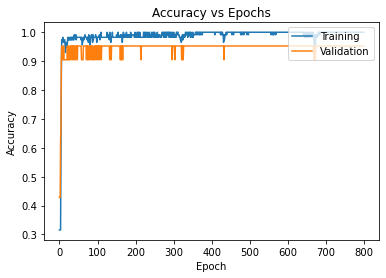

In [7]:
#plot learning curves
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except Keyerror:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(["Training", "Validation"], loc = 'upper right')
plt.show()

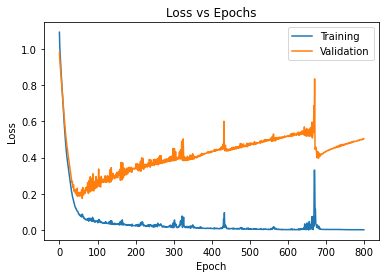

In [8]:
#epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

In [9]:
#regularized model
def get_regularized_model(input_shape, dropout_rate, weight_decay):
    """
    Build a regularised Sequential model according to the above specification. 
    The dropout_rate argument in the function is used to set the Dropout rate for all Dropout layers.
    L2 kernel regularisation (weight decay) is added using the weight_decay argument to set the weight decay coefficient in all 
    Dense layers that use L2 regularisation.
    Your function should return the model.
    """
    l2_reg = tf.keras.regularizers.L2(l2 = weight_decay )
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape = (train_data.shape[1],), 
                              kernel_initializer = tf.keras.initializers.HeUniform(),
                              bias_initializer = tf.keras.initializers.Constant(value=0),
                              kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(3, activation = 'softmax'),
        
    ])
    return model
#Instantiate the model, using a dropout rate of 0.3 and weight decay coefficient of 0.001
reg_model = get_regularized_model(train_data[0].shape, 0.3, 0.001)
compile_model(reg_model) # Compile the model
reg_history = train_model(reg_model, train_data, train_targets, epochs = 800) # Train the model

Epoch 1/800
3/3 [==============================] - 1s 110ms/step - loss: 1.9995 - accuracy: 0.2544 - val_loss: 1.8756 - val_accuracy: 0.4286
Epoch 2/800
3/3 [==============================] - 0s 13ms/step - loss: 1.9895 - accuracy: 0.2807 - val_loss: 1.8693 - val_accuracy: 0.4286
Epoch 3/800
3/3 [==============================] - 0s 15ms/step - loss: 1.9541 - accuracy: 0.3509 - val_loss: 1.8621 - val_accuracy: 0.4286
Epoch 4/800
3/3 [==============================] - 0s 15ms/step - loss: 1.9574 - accuracy: 0.3158 - val_loss: 1.8564 - val_accuracy: 0.4286
Epoch 5/800
3/3 [==============================] - 0s 15ms/step - loss: 1.9631 - accuracy: 0.2632 - val_loss: 1.8508 - val_accuracy: 0.4286
Epoch 6/800
3/3 [==============================] - 0s 14ms/step - loss: 1.9840 - accuracy: 0.2982 - val_loss: 1.8452 - val_accuracy: 0.4286
Epoch 7/800
3/3 [==============================] - 0s 14ms/step - loss: 1.9304 - accuracy: 0.4211 - val_loss: 1.8393 - val_accuracy: 0.4286
Epoch 8/800
3/3 [==

3/3 [==============================] - 0s 19ms/step - loss: 1.3448 - accuracy: 0.7368 - val_loss: 1.3058 - val_accuracy: 0.7143
Epoch 60/800
3/3 [==============================] - 0s 16ms/step - loss: 1.3251 - accuracy: 0.7105 - val_loss: 1.2989 - val_accuracy: 0.7143
Epoch 61/800
3/3 [==============================] - 0s 19ms/step - loss: 1.3033 - accuracy: 0.7719 - val_loss: 1.2930 - val_accuracy: 0.7143
Epoch 62/800
3/3 [==============================] - 0s 14ms/step - loss: 1.3081 - accuracy: 0.7193 - val_loss: 1.2870 - val_accuracy: 0.7143
Epoch 63/800
3/3 [==============================] - 0s 17ms/step - loss: 1.2702 - accuracy: 0.7719 - val_loss: 1.2813 - val_accuracy: 0.7143
Epoch 64/800
3/3 [==============================] - 0s 15ms/step - loss: 1.2723 - accuracy: 0.7807 - val_loss: 1.2752 - val_accuracy: 0.7619
Epoch 65/800
3/3 [==============================] - 0s 16ms/step - loss: 1.3139 - accuracy: 0.7281 - val_loss: 1.2688 - val_accuracy: 0.7619
Epoch 66/800
3/3 [========

3/3 [==============================] - 0s 23ms/step - loss: 0.9160 - accuracy: 0.9561 - val_loss: 0.9631 - val_accuracy: 0.8571
Epoch 118/800
3/3 [==============================] - 0s 18ms/step - loss: 0.9008 - accuracy: 0.9474 - val_loss: 0.9517 - val_accuracy: 0.8571
Epoch 119/800
3/3 [==============================] - 0s 13ms/step - loss: 0.8912 - accuracy: 0.9561 - val_loss: 0.9437 - val_accuracy: 0.9048
Epoch 120/800
3/3 [==============================] - 0s 11ms/step - loss: 0.8889 - accuracy: 0.9649 - val_loss: 0.9333 - val_accuracy: 0.9048
Epoch 121/800
3/3 [==============================] - 0s 11ms/step - loss: 0.8653 - accuracy: 0.9825 - val_loss: 0.9257 - val_accuracy: 0.9048
Epoch 122/800
3/3 [==============================] - 0s 11ms/step - loss: 0.8996 - accuracy: 0.9474 - val_loss: 0.9218 - val_accuracy: 0.9048
Epoch 123/800
3/3 [==============================] - 0s 12ms/step - loss: 0.8864 - accuracy: 0.9561 - val_loss: 0.9229 - val_accuracy: 0.9048
Epoch 124/800
3/3 [=

Epoch 175/800
3/3 [==============================] - 0s 12ms/step - loss: 0.7925 - accuracy: 0.9737 - val_loss: 0.9400 - val_accuracy: 0.9048
Epoch 176/800
3/3 [==============================] - 0s 11ms/step - loss: 0.7996 - accuracy: 0.9737 - val_loss: 0.9362 - val_accuracy: 0.9048
Epoch 177/800
3/3 [==============================] - 0s 12ms/step - loss: 0.8783 - accuracy: 0.9474 - val_loss: 0.9035 - val_accuracy: 0.9048
Epoch 178/800
3/3 [==============================] - 0s 12ms/step - loss: 0.7871 - accuracy: 0.9649 - val_loss: 0.8849 - val_accuracy: 0.9524
Epoch 179/800
3/3 [==============================] - 0s 13ms/step - loss: 0.7894 - accuracy: 0.9737 - val_loss: 0.8882 - val_accuracy: 0.9524
Epoch 180/800
3/3 [==============================] - 0s 13ms/step - loss: 0.7449 - accuracy: 1.0000 - val_loss: 0.8859 - val_accuracy: 0.9524
Epoch 181/800
3/3 [==============================] - 0s 13ms/step - loss: 0.8253 - accuracy: 0.9737 - val_loss: 0.8795 - val_accuracy: 0.9524
Epoch 

Epoch 233/800
3/3 [==============================] - 0s 15ms/step - loss: 0.7656 - accuracy: 0.9649 - val_loss: 0.9228 - val_accuracy: 0.9048
Epoch 234/800
3/3 [==============================] - 0s 14ms/step - loss: 0.7371 - accuracy: 0.9825 - val_loss: 0.9128 - val_accuracy: 0.9048
Epoch 235/800
3/3 [==============================] - 0s 24ms/step - loss: 0.7496 - accuracy: 0.9825 - val_loss: 0.9111 - val_accuracy: 0.9048
Epoch 236/800
3/3 [==============================] - 0s 16ms/step - loss: 0.7787 - accuracy: 0.9649 - val_loss: 0.9126 - val_accuracy: 0.9048
Epoch 237/800
3/3 [==============================] - 0s 11ms/step - loss: 0.7286 - accuracy: 0.9912 - val_loss: 0.9251 - val_accuracy: 0.9048
Epoch 238/800
3/3 [==============================] - 0s 12ms/step - loss: 0.7329 - accuracy: 0.9912 - val_loss: 0.9328 - val_accuracy: 0.9048
Epoch 239/800
3/3 [==============================] - 0s 12ms/step - loss: 0.7294 - accuracy: 0.9737 - val_loss: 0.9395 - val_accuracy: 0.9048
Epoch 

Epoch 291/800
3/3 [==============================] - 0s 12ms/step - loss: 0.7232 - accuracy: 0.9649 - val_loss: 0.8873 - val_accuracy: 0.9048
Epoch 292/800
3/3 [==============================] - 0s 11ms/step - loss: 0.7368 - accuracy: 0.9737 - val_loss: 0.8916 - val_accuracy: 0.9048
Epoch 293/800
3/3 [==============================] - 0s 11ms/step - loss: 0.7055 - accuracy: 0.9825 - val_loss: 0.8975 - val_accuracy: 0.9048
Epoch 294/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.9737 - val_loss: 0.8973 - val_accuracy: 0.9048
Epoch 295/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6880 - accuracy: 0.9825 - val_loss: 0.8919 - val_accuracy: 0.9048
Epoch 296/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6902 - accuracy: 0.9825 - val_loss: 0.8890 - val_accuracy: 0.9048
Epoch 297/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.9825 - val_loss: 0.8877 - val_accuracy: 0.9048
Epoch 

3/3 [==============================] - 0s 12ms/step - loss: 0.6801 - accuracy: 0.9825 - val_loss: 0.9122 - val_accuracy: 0.9048
Epoch 349/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6779 - accuracy: 0.9825 - val_loss: 0.9096 - val_accuracy: 0.9048
Epoch 350/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6719 - accuracy: 0.9825 - val_loss: 0.9132 - val_accuracy: 0.9048
Epoch 351/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6574 - accuracy: 0.9912 - val_loss: 0.9165 - val_accuracy: 0.9048
Epoch 352/800
3/3 [==============================] - 0s 12ms/step - loss: 0.6516 - accuracy: 0.9912 - val_loss: 0.9201 - val_accuracy: 0.9048
Epoch 353/800
3/3 [==============================] - 0s 13ms/step - loss: 0.6690 - accuracy: 0.9825 - val_loss: 0.9214 - val_accuracy: 0.9048
Epoch 354/800
3/3 [==============================] - 0s 14ms/step - loss: 0.6857 - accuracy: 0.9737 - val_loss: 0.9228 - val_accuracy: 0.9048
Epoch 355/800
3/3 [=

Epoch 406/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6857 - accuracy: 0.9649 - val_loss: 0.8778 - val_accuracy: 0.9048
Epoch 407/800
3/3 [==============================] - 0s 12ms/step - loss: 0.6844 - accuracy: 0.9737 - val_loss: 0.8846 - val_accuracy: 0.9048
Epoch 408/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6481 - accuracy: 0.9825 - val_loss: 0.8824 - val_accuracy: 0.9048
Epoch 409/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6265 - accuracy: 1.0000 - val_loss: 0.8742 - val_accuracy: 0.9048
Epoch 410/800
3/3 [==============================] - 0s 12ms/step - loss: 0.6165 - accuracy: 1.0000 - val_loss: 0.8651 - val_accuracy: 0.9048
Epoch 411/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6442 - accuracy: 0.9912 - val_loss: 0.8554 - val_accuracy: 0.9048
Epoch 412/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6691 - accuracy: 0.9561 - val_loss: 0.8557 - val_accuracy: 0.9048
Epoch 

Epoch 464/800
3/3 [==============================] - 0s 15ms/step - loss: 0.6475 - accuracy: 0.9825 - val_loss: 0.8544 - val_accuracy: 0.9048
Epoch 465/800
3/3 [==============================] - 0s 15ms/step - loss: 0.6258 - accuracy: 0.9825 - val_loss: 0.8317 - val_accuracy: 0.9048
Epoch 466/800
3/3 [==============================] - 0s 16ms/step - loss: 0.6107 - accuracy: 0.9912 - val_loss: 0.8166 - val_accuracy: 0.9048
Epoch 467/800
3/3 [==============================] - 0s 14ms/step - loss: 0.6273 - accuracy: 0.9912 - val_loss: 0.8100 - val_accuracy: 0.9048
Epoch 468/800
3/3 [==============================] - 0s 14ms/step - loss: 0.7301 - accuracy: 0.9561 - val_loss: 0.8072 - val_accuracy: 0.9048
Epoch 469/800
3/3 [==============================] - 0s 14ms/step - loss: 0.6507 - accuracy: 0.9737 - val_loss: 0.8151 - val_accuracy: 0.9048
Epoch 470/800
3/3 [==============================] - 0s 16ms/step - loss: 0.6222 - accuracy: 0.9825 - val_loss: 0.8318 - val_accuracy: 0.9048
Epoch 

3/3 [==============================] - 0s 23ms/step - loss: 0.5920 - accuracy: 1.0000 - val_loss: 0.8322 - val_accuracy: 0.9048
Epoch 522/800
3/3 [==============================] - 0s 21ms/step - loss: 0.6031 - accuracy: 0.9912 - val_loss: 0.8273 - val_accuracy: 0.9048
Epoch 523/800
3/3 [==============================] - 0s 16ms/step - loss: 0.6053 - accuracy: 0.9912 - val_loss: 0.8253 - val_accuracy: 0.9048
Epoch 524/800
3/3 [==============================] - 0s 11ms/step - loss: 0.6003 - accuracy: 0.9825 - val_loss: 0.8265 - val_accuracy: 0.9048
Epoch 525/800
3/3 [==============================] - 0s 17ms/step - loss: 0.5852 - accuracy: 1.0000 - val_loss: 0.8273 - val_accuracy: 0.9048
Epoch 526/800
3/3 [==============================] - 0s 14ms/step - loss: 0.6260 - accuracy: 0.9825 - val_loss: 0.8143 - val_accuracy: 0.9048
Epoch 527/800
3/3 [==============================] - 0s 16ms/step - loss: 0.6046 - accuracy: 0.9912 - val_loss: 0.8084 - val_accuracy: 0.9048
Epoch 528/800
3/3 [=

Epoch 579/800
3/3 [==============================] - 0s 14ms/step - loss: 0.5869 - accuracy: 0.9912 - val_loss: 0.8165 - val_accuracy: 0.9048
Epoch 580/800
3/3 [==============================] - 0s 13ms/step - loss: 0.5944 - accuracy: 0.9912 - val_loss: 0.7958 - val_accuracy: 0.9048
Epoch 581/800
3/3 [==============================] - 0s 12ms/step - loss: 0.5869 - accuracy: 0.9912 - val_loss: 0.7991 - val_accuracy: 0.9048
Epoch 582/800
3/3 [==============================] - 0s 13ms/step - loss: 0.5897 - accuracy: 0.9912 - val_loss: 0.8052 - val_accuracy: 0.9048
Epoch 583/800
3/3 [==============================] - 0s 13ms/step - loss: 0.5871 - accuracy: 0.9912 - val_loss: 0.8095 - val_accuracy: 0.9048
Epoch 584/800
3/3 [==============================] - 0s 13ms/step - loss: 0.6358 - accuracy: 0.9737 - val_loss: 0.8181 - val_accuracy: 0.9048
Epoch 585/800
3/3 [==============================] - 0s 14ms/step - loss: 0.5843 - accuracy: 0.9912 - val_loss: 0.8324 - val_accuracy: 0.9048
Epoch 

Epoch 637/800
3/3 [==============================] - 0s 14ms/step - loss: 0.6054 - accuracy: 0.9825 - val_loss: 0.8353 - val_accuracy: 0.9048
Epoch 638/800
3/3 [==============================] - 0s 14ms/step - loss: 0.5945 - accuracy: 0.9649 - val_loss: 0.8506 - val_accuracy: 0.9048
Epoch 639/800
3/3 [==============================] - 0s 14ms/step - loss: 0.5679 - accuracy: 0.9912 - val_loss: 0.8494 - val_accuracy: 0.9048
Epoch 640/800
3/3 [==============================] - 0s 14ms/step - loss: 0.5785 - accuracy: 0.9912 - val_loss: 0.8476 - val_accuracy: 0.9048
Epoch 641/800
3/3 [==============================] - 0s 14ms/step - loss: 0.5867 - accuracy: 0.9825 - val_loss: 0.8375 - val_accuracy: 0.9048
Epoch 642/800
3/3 [==============================] - 0s 13ms/step - loss: 0.5923 - accuracy: 0.9649 - val_loss: 0.8183 - val_accuracy: 0.9048
Epoch 643/800
3/3 [==============================] - 0s 13ms/step - loss: 0.5609 - accuracy: 1.0000 - val_loss: 0.7893 - val_accuracy: 0.9048
Epoch 

Epoch 695/800
3/3 [==============================] - 0s 17ms/step - loss: 0.5557 - accuracy: 0.9825 - val_loss: 0.8037 - val_accuracy: 0.9048
Epoch 696/800
3/3 [==============================] - 0s 15ms/step - loss: 0.5578 - accuracy: 0.9825 - val_loss: 0.8379 - val_accuracy: 0.9048
Epoch 697/800
3/3 [==============================] - 0s 15ms/step - loss: 0.5828 - accuracy: 0.9737 - val_loss: 0.8526 - val_accuracy: 0.9048
Epoch 698/800
3/3 [==============================] - 0s 15ms/step - loss: 0.5411 - accuracy: 1.0000 - val_loss: 0.8499 - val_accuracy: 0.9048
Epoch 699/800
3/3 [==============================] - 0s 16ms/step - loss: 0.5474 - accuracy: 1.0000 - val_loss: 0.8503 - val_accuracy: 0.9048
Epoch 700/800
3/3 [==============================] - 0s 16ms/step - loss: 0.5681 - accuracy: 0.9825 - val_loss: 0.8633 - val_accuracy: 0.9048
Epoch 701/800
3/3 [==============================] - 0s 16ms/step - loss: 0.5925 - accuracy: 0.9737 - val_loss: 0.8492 - val_accuracy: 0.9048
Epoch 

Epoch 753/800
3/3 [==============================] - 0s 22ms/step - loss: 0.5469 - accuracy: 0.9912 - val_loss: 0.8391 - val_accuracy: 0.9048
Epoch 754/800
3/3 [==============================] - 0s 30ms/step - loss: 0.5566 - accuracy: 0.9912 - val_loss: 0.8454 - val_accuracy: 0.9048
Epoch 755/800
3/3 [==============================] - 0s 28ms/step - loss: 0.5708 - accuracy: 0.9825 - val_loss: 0.8366 - val_accuracy: 0.9048
Epoch 756/800
3/3 [==============================] - 0s 27ms/step - loss: 0.5660 - accuracy: 0.9825 - val_loss: 0.8225 - val_accuracy: 0.9048
Epoch 757/800
3/3 [==============================] - 0s 16ms/step - loss: 0.5425 - accuracy: 0.9912 - val_loss: 0.7975 - val_accuracy: 0.9048
Epoch 758/800
3/3 [==============================] - 0s 14ms/step - loss: 0.5398 - accuracy: 0.9912 - val_loss: 0.7789 - val_accuracy: 0.9048
Epoch 759/800
3/3 [==============================] - 0s 15ms/step - loss: 0.5486 - accuracy: 0.9912 - val_loss: 0.7668 - val_accuracy: 0.9048
Epoch 

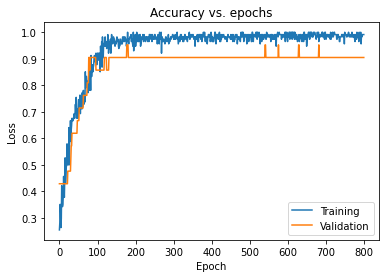

In [10]:
#accuracy vs epoch graph
try:
    plt.plot(reg_history.history['accuracy'])
    plt.plot(reg_history.history['val_accuracy'])
except KeyError:
    plt.plot(reg_history.history['acc'])
    plt.plot(reg_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

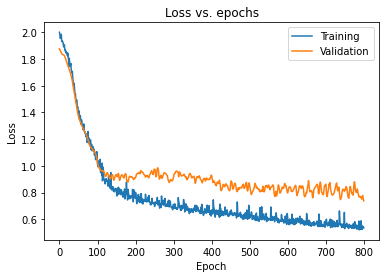

In [11]:
#new loss vs epoch graph
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [12]:
#callbacks for earl stopping and learning rate reduction
def get_callbacks():
    """
    Create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    The callbacks are instantiated according to the above requirements.
    """
    earlystopping = tf.keras.callbacks.EarlyStopping(mode='min', patience = 30)
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=20)
    return earlystopping, learning_rate_reduction



In [13]:
call_model = get_regularized_model(train_data[0].shape, 0.3, 0.0001) #initialize the model
compile_model(call_model) #compile the model
early_stopping, learning_rate_reduction = get_callbacks() #initialize callbacks

#model traiing
call_history = call_model.fit(train_data, train_targets, epochs = 800, validation_split = 0.15,
                             callbacks = [early_stopping, learning_rate_reduction], verbose = 0)

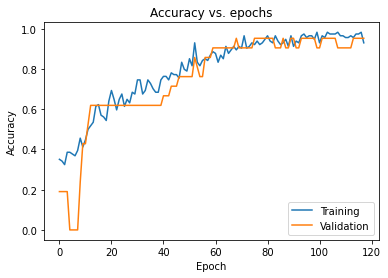

In [14]:
#accuracy vs epochs graph
try:
    plt.plot(call_history.history['accuracy'])
    plt.plot(call_history.history['val_accuracy'])
except KeyError:
    plt.plot(call_history.history['acc'])
    plt.plot(call_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

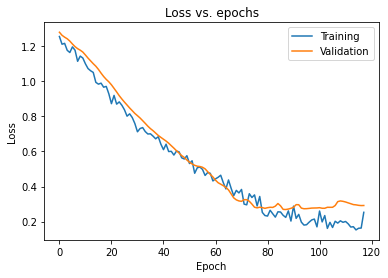

In [15]:
#accuracy vs loss graph
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [16]:
#model evaluation
test_loss, test_acc = call_model.evaluate(test_data, test_targets, verbose = 0)
print("Test loss: {:.4f}\nTest accuracy: {:.2f}%".format(test_loss, 100*test_acc))

Test loss: 0.1070
Test accuracy: 100.00%
